In [3]:
## Process AlpArray Switzerland for SKS-Splitting
## Gerrit Hein
######################################################
######### LOAD IN THE MODULES
######################################################
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import matplotlib.pyplot as plt
import numpy as np

import os
import obspy
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import TauPyModel
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.taup import plot_travel_times
from obspy.geodetics import locations2degrees
from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.polarization import particle_motion_odr

from obspy.signal.util import next_pow_2

import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

from matplotlib.mlab import specgram
from scipy import stats


from tqdm import tqdm
import time

import multiprocessing

import splitwavepy as sw
######################################################
### 
######################################################



In [22]:

station = filter(None, station)
print(station)

['ABR', 'AIGLE', 'ANTF', 'ARBF', 'BALST', 'BERNI', 'BLB', 'BRANT', 'CALF', 'DAVOX', 'DIX', 'EMV', 'ESCA', 'FIR', 'FUSIO', 'GIMEL', 'GUA', 'HASLI', 'ISO', 'LAU', 'LEPF', 'LIENZ', 'LLS', 'MMK', 'MUGIO', 'MUO', 'NON', 'OGAG', 'OGDI', 'PCP', 'PLONS', 'PRI', 'RORO', 'RSP', 'RUSF', 'SAOF', 'SLE', 'SMPL', 'STET', 'STV', 'SULZ', 'TORNY', 'VAL', 'VAT', 'VDL', 'VIN', 'WILA', 'WIMIS', 'ZUR']


In [46]:
## load in Barruol values
import csv

path = '/media/hein/home2/SKS_automatic_splitwave/code_latest/'

station = ['']*60
lat = ['']*60
lon = ['']*60
fast = ['']*60
dfast= ['']*60
lag= ['']*60
dlag= ['']*60
nSKS = ['']*60

with open(path+'Barruol_values.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    
    for row in csv_reader:
#        print(row)
        if line_count == 0:
            print('HEADER')
            print(row)
            line_count += 1
        else:
            station[line_count] = row[0]
            lat[line_count] = float(row[1])
            lon[line_count] = float(row[2])
            a = ['1','2','3','4','5','6','7','8','9','0']
            if row[3][0] in a:
                fast[line_count] = float(row[3][-5:])
            else:
                fast[line_count] = -1*float(row[3][-5:])
                
            dfast[line_count] = float(row[4])
            lag[line_count] = float(row[5])
            dlag[line_count] = float(row[6])
            nSKS[line_count] = float(row[7])            

            line_count += 1
#     print(f'Processed {line_count} lines.')


HEADER
['Station', 'Lat. (\xc2\xb0N)', 'Lon. (\xc2\xb0E)', '\xcf\x95 (\xc2\xb0)', 'Error_\xcf\x95 (\xc2\xb0)', '\xce\xb4t (s)', 'Error_\xce\xb4t (s)', 'Number of measurements']


In [47]:
station = filter(None, station)
lat = filter(None, lat)
lon = filter(None, lon)
fast = filter(None, fast)
dfast = filter(None, dfast)
lag = filter(None, lag)
dlag = filter(None, dlag)
nSKS = filter(None, nSKS)



## function to plot 
## Tasks: 

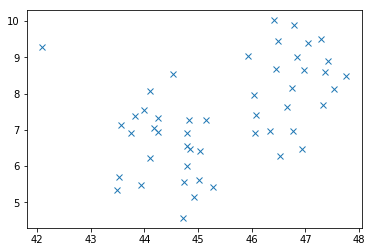

In [50]:
plt.plot(lat,lon,'x')

In [2]:
def read_SKS_files(path,filename):
    filename = '{0}/{1}'.format(path,filename) #removed first two header lines
    with open(filename) as f:
        content = f.readlines()

    station = ['']*len(content) 
    dt = ['']*len(content) 
    dtlag  = ['']*len(content) 
    fast_dir = ['']*len(content) 
    dfast_dir = ['']*len(content) 

    for i in range(1,len(content)-1):
        data = zip_longest(*(x.split(' ') for x in content[i].splitlines()), fillvalue='\t')

        for row in zip(*data):
            new_data = tuple(np.nan if x == '' else x for x in row)
            line = new_data
            station[i] = line[0][1:-1]            
            dt[i] = float(line[1][1:-2])
            dtlag[i] = float(line[2][1:-2])          
            fast_dir[i] = float(line[3][1:-2])            
            dfast_dir[i] = float(line[4][1:-2])                        

    station = np.asarray(station[1:-1])
    dt = np.asarray(dt[1:-1])
    dtlag = np.asarray(dtlag[1:-1])
    fast_dir = np.asarray(fast_dir[1:-1])
    ## convert from -90-90 to 0-180    
    fast_dir = (fast_dir+180)%180    
    dfast_dir = np.asarray(dfast_dir[1:-1])    
        
    return station,dt,dtlag,fast_dir,dfast_dir


In [ ]:
header='Station.code, ' + \
        'Station.lat [°],' + \
        'Station.lon [°],' + \
        'Event time, ' + \
        'Event depth [km], ' + \
        'Event mag, '+ \
        'Event lat [°], ' + \
        'Event lon [°], ' + \
        'best fast dir [°], ' + \
        'dfast dir [°], ' +\
        'best lag [s], ' + \
        'dlag [s], ' + \
        'SNR [dB], ' + \
        'window param t1 [s], ' + \
        'window param t2 [s], ' + \
        'Chi-Squared-phi ' + \
        'p-value-phi, ' + \
        'Chi-Squared-dt, ' + \
        'p-value-dt'

header2='Station.code, ' + \
        'fast dir [°]' + \
        'dfast dir [°], ' + \
        'dt [s],' + \
        'dlag [s],' + \
        'Chi-Squared-phi ' + \
        'p-value-phi, ' + \
        'Chi-Squared-dt, ' + \
        'p-value-dt' + \
        'number Events'
